In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import fbeta_score


def generate_wsn_dataset(n_samples=200):
    np.random.seed(42)
    data = pd.DataFrame({
        'residual_energy': np.random.rand(n_samples),
        'distance_to_sink': np.random.rand(n_samples) * 100,
        'link_quality': np.random.rand(n_samples),
        'is_reliable': np.random.randint(0, 2, n_samples)
    })
    data['suitable_for_routing'] = (
        (data['residual_energy'] > 0.4) &
        (data['distance_to_sink'] < 60) &
        (data['link_quality'] > 0.5) &
        (data['is_reliable'] == 1)
    ).astype(int)
    return data

def train_dt_model(data):
    X = data[['residual_energy', 'distance_to_sink', 'link_quality', 'is_reliable']]
    y = data['suitable_for_routing']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = DecisionTreeClassifier(max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)

    return {'accuracy': accuracy, 'report': report}

def simulate_q_learning(data):
    X = data[['residual_energy', 'distance_to_sink', 'link_quality', 'is_reliable']]
    y = data['suitable_for_routing']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    def discretize(value, bins):
        return np.digitize(value, bins) - 1

    energy_bins = np.linspace(0, 1, 4)
    distance_bins = np.linspace(0, 100, 4)
    link_bins = np.linspace(0, 1, 4)

    num_states = 3 * 3 * 3
    num_actions = 2
    Q_table = np.zeros((num_states, num_actions))

    alpha = 0.1
    gamma = 0.9
    epsilon = 0.2

    for episode in range(500):
        for i in range(len(X_train)):
            s1 = discretize(X_train.iloc[i]['residual_energy'], energy_bins)
            s2 = discretize(X_train.iloc[i]['distance_to_sink'], distance_bins)
            s3 = discretize(X_train.iloc[i]['link_quality'], link_bins)
            state = s1 * 9 + s2 * 3 + s3

            action = np.random.choice(num_actions) if np.random.rand() < epsilon else np.argmax(Q_table[state])
            reward = 1 if action == y_train.iloc[i] else -1

            Q_table[state, action] += alpha * (reward + gamma * np.max(Q_table[state]) - Q_table[state, action])

    y_pred = []
    for i in range(len(X_test)):
        s1 = discretize(X_test.iloc[i]['residual_energy'], energy_bins)
        s2 = discretize(X_test.iloc[i]['distance_to_sink'], distance_bins)
        s3 = discretize(X_test.iloc[i]['link_quality'], link_bins)
        state = s1 * 9 + s2 * 3 + s3
        action = np.argmax(Q_table[state])
        y_pred.append(action)

    y_pred = np.array(y_pred)
    y_true = y_test.to_numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # f2 = f1_score(y_true, y_pred, beta=2, zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0)


    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'f2-score': f2
    }

def compare_models(dt_result, q_result):
    print("=== Decision Tree Performance ===")
    print(f"Accuracy: {dt_result['accuracy'] * 100:.2f}%")
    for label, metrics in dt_result['report'].items():
        if isinstance(metrics, dict) and label in ['0', '1']:
            print(f"Class {label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1={metrics['f1-score']:.2f}")

    print("\n=== Q-Learning Performance ===")
    for key, value in q_result.items():
        print(f"{key.capitalize()}: {value:.2f}")

def visualize_results(dt_result, q_result):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'f2-score']
    dt_metrics = [
        dt_result.get('accuracy', 0),
        dt_result['report']['1'].get('precision', 0),
        dt_result['report']['1'].get('recall', 0),
        dt_result['report']['1'].get('f1-score', 0),
        0  # F2-score not available
    ]
    q_metrics = [
        q_result.get('accuracy', 0),
        q_result.get('precision', 0),
        q_result.get('recall', 0),
        q_result.get('f1-score', 0),
        q_result.get('f2-score', 0)
    ]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 5))
    bars1 = ax.bar(x - width/2, dt_metrics, width, label='Decision Tree', color='skyblue')
    bars2 = ax.bar(x + width/2, q_metrics, width, label='Q-Learning', color='salmon')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


=== Decision Tree Performance ===
Accuracy: 98.33%
Class 0: Precision=0.98, Recall=1.00, F1=0.99
Class 1: Precision=1.00, Recall=0.75, F1=0.86

=== Q-Learning Performance ===
Accuracy: 0.93
Precision: 0.50
Recall: 0.25
F1-score: 0.33
F2-score: 0.28


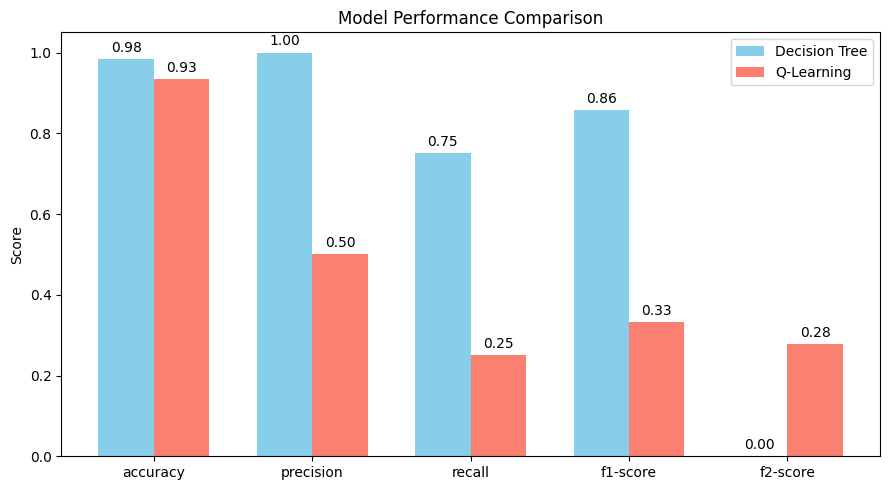

In [ ]:
data = generate_wsn_dataset()
dt_result = train_dt_model(data)
q_result = simulate_q_learning(data)

compare_models(dt_result, q_result)
visualize_results(dt_result, q_result)
